# TP2 Álgebra Lineal Computacional

## Procesamiento de datos

1. Cargo el archivo "Tabla nutricional", lleno los datos nulos con 0 y modifico los valores para que todos estén en la misma unidad de medida (gr)

In [62]:
#Leo el archivo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("tabla_nutricional.csv", encoding='latin_1',delimiter=';')

consumidores_libres = pd.read_csv("consumidores_libres.csv", encoding='latin_1',delimiter=';')

In [63]:
#Completo con ceros
tn = df.fillna(0)

#Cambio todas las unidades de medida a gr
nuevosNombres = {}
for col in tn.columns:
    if "mg" in col:
        tn[col] = tn[col]/1000
    nuevosNombres[col] = col.replace('mg','gr')
tn = tn.rename(columns=nuevosNombres)

## Consigna 2 - Definimos la función cumpleMargen

Podemos observar que nuestra tabla nutricional no cumple el margen de ingesta nutricional de la OMS

In [64]:
def cumpleMargen(data):
    proteinas = data[data.columns[3]].sum()
    grasas = data[data.columns[4]].sum()
    carbohidratos = data[data.columns[2]].sum()
    sodio = data[data.columns[5]].sum()
    fibras = data[data.columns[12]].sum()

    total = proteinas + grasas + carbohidratos + sodio + fibras

    frutasYverduras = data.loc[data['Alimento'].isin(["Acelga","Zanahoria","Tomate","Lechuga","Cebolla","Zapallo","Manzana","Naranja","Mandarina","pera","Banana","Papa","Batata","Tomate envasado"])]
    frutVer = frutasYverduras[frutasYverduras.columns[1]].sum()

    
    res = True
    if (grasas < total * 0.15) or (grasas > total * 0.30):
        res = False
    elif (carbohidratos < total * 0.55) or (carbohidratos > total * 0.75):
        res = False
    elif(proteinas < total * 0.10) or (proteinas > total * 0.15):
        res = False
    elif (sodio < 200):
        res = False
    elif (fibras < 25):
        res = False
    elif (frutVer < 400):
        res = False
    return res

print("Cumple margen (tabla nutricional):",cumpleMargen(tn))

Cumple margen (tabla nutricional): False


## Consigna 3 - Realizamos un ACP con los datos de la tabla nutricional

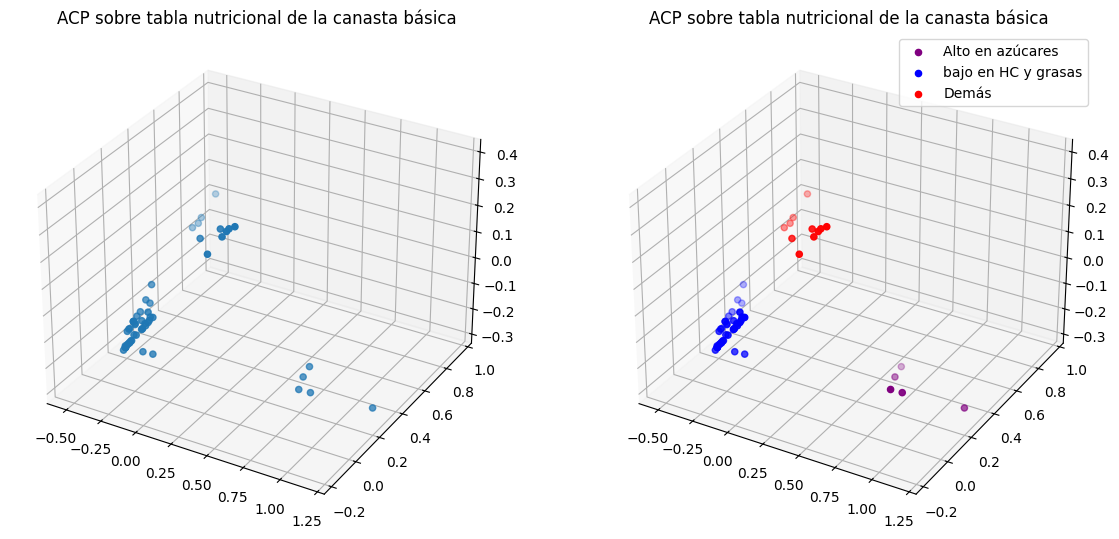

In [65]:
# Modifico la tabla para que me muestre los nutrientes por gramo

cantidades = tn[tn.columns[1]]
tn0 = tn.copy()
for i in range(tn.shape[0]):
    tn0.iloc[i,1:] = tn0.iloc[i,1:]/cantidades[i]

# Divido la tabla por tipo de alimento

Azucarados = tn0[tn0["Azucares Libres (gr)"]>0.5]["Alimento"]
pocoHC = tn0[(tn0["HC (gr)"]<0.3) & (tn0["Grasas (gr)"]<0.7)]["Alimento"]


tnAzucarados = tn0.loc[tn0['Alimento'].isin(Azucarados)]
tnPocoHC = tn0.loc[tn0['Alimento'].isin(pocoHC)]


tnResto = tn0.loc[~tn0['Alimento'].isin(Azucarados)]
tnResto = tnResto.loc[~tn0['Alimento'].isin(pocoHC)]

#

tnMedias = np.mean(tn0.iloc[:,2:], axis=0)

tnCentrado = tn0.iloc[:,2:]
for i in range(tnCentrado.shape[1]):
    tnCentrado[tnCentrado.columns[i]] = tnCentrado[tnCentrado.columns[i]] - tnMedias[i]

# 

tnRestoCentrado = tnResto.iloc[:,2:]
for i in range(tnRestoCentrado.shape[1]):
    tnRestoCentrado[tnRestoCentrado.columns[i]] = tnRestoCentrado[tnRestoCentrado.columns[i]] - tnMedias[i]

tnAzucaradosCentrado = tnAzucarados.iloc[:,2:]
for i in range(tnAzucaradosCentrado.shape[1]):
    tnAzucaradosCentrado[tnAzucaradosCentrado.columns[i]] = tnAzucaradosCentrado[tnAzucaradosCentrado.columns[i]] - tnMedias[i]

tnpocoHCentrado = tnPocoHC.iloc[:,2:]
for i in range(tnpocoHCentrado.shape[1]):
    tnpocoHCentrado[tnpocoHCentrado.columns[i]] = tnpocoHCentrado[tnpocoHCentrado.columns[i]] - tnMedias[i]


#

U, S, Vt = np.linalg.svd(tnCentrado)
V_reducido = Vt[:3,:]

tnProyecciones = np.dot(tnCentrado,V_reducido.T)

tnAzucaradosProyecciones = np.dot(tnAzucaradosCentrado,V_reducido.T)
tnPocoHCProyecciones = np.dot(tnpocoHCentrado,V_reducido.T)
tnProyeccionesResto = np.dot(tnRestoCentrado,V_reducido.T)

fig = plt.figure(figsize=(14,28))
ax = fig.add_subplot(121,projection='3d')
ax.scatter(tnProyecciones[:,0],tnProyecciones[:,1],tnProyecciones[:,2])
ax.set_title("ACP sobre tabla nutricional de la canasta básica")

ax = fig.add_subplot(122,projection='3d')
ax.scatter(tnAzucaradosProyecciones[:,0],tnAzucaradosProyecciones[:,1],tnAzucaradosProyecciones[:,2],color="purple", label = "Alto en azúcares")
ax.scatter(tnPocoHCProyecciones[:,0],tnPocoHCProyecciones[:,1],tnPocoHCProyecciones[:,2],color="blue", label = "bajo en HC y grasas")
ax.scatter(tnProyeccionesResto[:,0],tnProyeccionesResto[:,1],tnProyeccionesResto[:,2], color = "red", label = "Demás")
ax.set_title("ACP sobre tabla nutricional de la canasta básica")
ax.legend()
plt.show()

## Consigna 4 - Proyección de los elementos de la tabla Consumidores Libres sobre los generadores del ACP

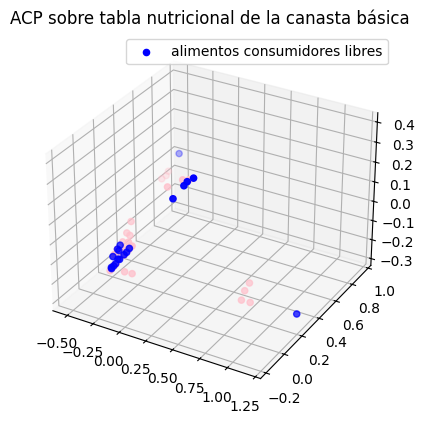

In [66]:
#Elementos de la tabla consumidores_libres
alim_cl = consumidores_libres["PRODUCTOS"].tolist()
#Reemplazo los nombres para que coincidan con los de la tabla nutricional
alim_cl[0] = "Aceite girasol"
alim_cl[1] = "Arroz"
alim_cl[2] = "Azucar"
alim_cl[3] = "Fideos secos"
alim_cl[4] = "Harina trigo"
alim_cl[5] = "Huevo" #En el precio hace referencia a la docena y en la tabla nutricional a los 16 huevos, para pensar
alim_cl[6] = "Pan Frances"
alim_cl[7] = "Leche fluida entera"
alim_cl[8] = "Yerba"
alim_cl[9] = "Zanahoria"
alim_cl[10] = "Berenjena" #No hay berenjena en la tabla nutricional ???
alim_cl[11] = "Tomate"
alim_cl[12] = "Cebolla"
alim_cl[13] = "Papa"
alim_cl[14] = "Acelga"
alim_cl[15] = "Naranja"
alim_cl[16] = "Manzana"
alim_cl[17] = "Bola de Lomo"
alim_cl[18] = "Asado"
alim_cl[19] = "Paleta"
alim_cl[20] = "Carne picada"


#DataFrame con los datos nutricionales de los elementos de la tabla consumidores_libres
cl_tn = tn0.loc[tn0['Alimento'].isin(alim_cl)]
tnResto = tn0.loc[~tn0['Alimento'].isin(alim_cl)]

#Matriz del DataFrame
clCentrado = cl_tn.iloc[:,2:]

for i in range(clCentrado.shape[1]):
    clCentrado[clCentrado.columns[i]] = clCentrado[clCentrado.columns[i]] - tnMedias[i]

tnRestoCentrado = tnResto.iloc[:,2:]
for i in range(tnRestoCentrado.shape[1]):
    tnRestoCentrado[tnRestoCentrado.columns[i]] = tnRestoCentrado[tnRestoCentrado.columns[i]] - tnMedias[i]

proyec = np.dot(clCentrado,V_reducido.T)
tnProyeccionesResto = np.dot(tnRestoCentrado,V_reducido.T)

#Gráfico
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(proyec[:,0],proyec[:,1],proyec[:,2],color = "blue", label = "alimentos consumidores libres")
ax.scatter(tnProyeccionesResto[:,0],tnProyeccionesResto[:,1],tnProyeccionesResto[:,2], color = "pink")
ax.set_title("ACP sobre tabla nutricional de la canasta básica")
ax.legend()
plt.show()

# Consigna 5 - 

## Obtenemos los promedios del precio de cada nutriente por gramo mediante las comidas


### Promedio de precio por gramo de los carbohidratos según la fecha 

In [67]:
consum_libres = consumidores_libres.rename(columns={"PRODUCTOS": "Alimento", "Cantidad": "Cantidad (gr/ml)"})
consum_libres.iloc[:,0] = alim_cl
consum_libres = consum_libres.sort_values(by='Alimento')
consum_libres = consum_libres[consum_libres['Alimento'] != 'Berenjena']  #Eliminamos la berenjena de la tabla pues no está en la tabla nutricional

HC = tn[['Alimento', 'Cantidad (gr/ml)', 'HC (gr)']]
HC = HC.loc[HC['Alimento'].isin(alim_cl)]
HC.insert(3,'31/12/2023', np.zeros(HC.shape[0]))
HC.insert(4,'31/1/2024', np.zeros(HC.shape[0]))
HC.insert(5,'29/2/2024', np.zeros(HC.shape[0]))
HC.insert(6,'31/3/2024', np.zeros(HC.shape[0]))
HC.insert(7,'30/4/2024', np.zeros(HC.shape[0]))

HC = HC.sort_values('Alimento')
for i in range(HC.shape[0]):
    HC.iloc[i,3] = HC.iloc[i,1] * (consum_libres.iloc[i,2] / consum_libres.iloc[i,1])
    HC.iloc[i,4] = HC.iloc[i,1] * (consum_libres.iloc[i,3] / consum_libres.iloc[i,1])
    HC.iloc[i,5] = HC.iloc[i,1] * (consum_libres.iloc[i,4] / consum_libres.iloc[i,1])
    HC.iloc[i,6] = HC.iloc[i,1] * (consum_libres.iloc[i,5] / consum_libres.iloc[i,1])
    HC.iloc[i,7] = HC.iloc[i,1] * (consum_libres.iloc[i,6] / consum_libres.iloc[i,1])


HC = HC[HC['HC (gr)'] != 0]

HC.iloc[:,1:] = HC.iloc[:,1:].div(HC['HC (gr)'], axis=0)

promedioHC_fecha = [HC.iloc[:,3].sum()/HC.shape[0], HC.iloc[:,4].sum()/HC.shape[0], HC.iloc[:,5].sum()/HC.shape[0], HC.iloc[:,6].sum()/HC.shape[0], HC.iloc[:,7].sum()/HC.shape[0]]

### Promedio de precio por gramo de las proteínas según la fecha 

In [68]:
consum_libres = consumidores_libres.rename(columns={"PRODUCTOS": "Alimento", "Cantidad": "Cantidad (gr/ml)"})
consum_libres.iloc[:,0] = alim_cl
consum_libres = consum_libres.sort_values(by='Alimento')
consum_libres = consum_libres[consum_libres['Alimento'] != 'Berenjena']  #Eliminamos la berenjena de la tabla pues no está en la tabla nutricional

prot = tn[['Alimento', 'Cantidad (gr/ml)', 'Proteinas (gr)']]
prot = prot.loc[prot['Alimento'].isin(alim_cl)]
prot.insert(3,'31/12/2023', np.zeros(prot.shape[0]))
prot.insert(4,'31/1/2024', np.zeros(prot.shape[0]))
prot.insert(5,'29/2/2024', np.zeros(prot.shape[0]))
prot.insert(6,'31/3/2024', np.zeros(prot.shape[0]))
prot.insert(7,'30/4/2024', np.zeros(prot.shape[0]))

prot = prot.sort_values('Alimento')
for i in range(prot.shape[0]):
    prot.iloc[i,3] = prot.iloc[i,1] * (consum_libres.iloc[i,2] / consum_libres.iloc[i,1])
    prot.iloc[i,4] = prot.iloc[i,1] * (consum_libres.iloc[i,3] / consum_libres.iloc[i,1])
    prot.iloc[i,5] = prot.iloc[i,1] * (consum_libres.iloc[i,4] / consum_libres.iloc[i,1])
    prot.iloc[i,6] = prot.iloc[i,1] * (consum_libres.iloc[i,5] / consum_libres.iloc[i,1])
    prot.iloc[i,7] = prot.iloc[i,1] * (consum_libres.iloc[i,6] / consum_libres.iloc[i,1])


prot = prot[prot['Proteinas (gr)'] != 0]

prot.iloc[:,1:] = prot.iloc[:,1:].div(prot['Proteinas (gr)'], axis=0)

promedioProt_fecha = [prot.iloc[:,3].sum()/prot.shape[0], prot.iloc[:,4].sum()/prot.shape[0], prot.iloc[:,5].sum()/prot.shape[0], prot.iloc[:,6].sum()/prot.shape[0], prot.iloc[:,7].sum()/prot.shape[0]]


### Promedio de precio por gramo de las grasas según la fecha 

In [69]:
consum_libres = consumidores_libres.rename(columns={"PRODUCTOS": "Alimento", "Cantidad": "Cantidad (gr/ml)"})
consum_libres.iloc[:,0] = alim_cl
consum_libres = consum_libres.sort_values(by='Alimento')
consum_libres = consum_libres[consum_libres['Alimento'] != 'Berenjena']  #Eliminamos la berenjena de la tabla pues no está en la tabla nutricional

grasas = tn[['Alimento', 'Cantidad (gr/ml)', 'Grasas (gr)']]
grasas = grasas.loc[grasas['Alimento'].isin(alim_cl)]
grasas.insert(3,'31/12/2023', np.zeros(grasas.shape[0]))
grasas.insert(4,'31/1/2024', np.zeros(grasas.shape[0]))
grasas.insert(5,'29/2/2024', np.zeros(grasas.shape[0]))
grasas.insert(6,'31/3/2024', np.zeros(grasas.shape[0]))
grasas.insert(7,'30/4/2024', np.zeros(grasas.shape[0]))

grasas = grasas.sort_values('Alimento')
for i in range(grasas.shape[0]):
    grasas.iloc[i,3] = grasas.iloc[i,1] * (consum_libres.iloc[i,2] / consum_libres.iloc[i,1])
    grasas.iloc[i,4] = grasas.iloc[i,1] * (consum_libres.iloc[i,3] / consum_libres.iloc[i,1])
    grasas.iloc[i,5] = grasas.iloc[i,1] * (consum_libres.iloc[i,4] / consum_libres.iloc[i,1])
    grasas.iloc[i,6] = grasas.iloc[i,1] * (consum_libres.iloc[i,5] / consum_libres.iloc[i,1])
    grasas.iloc[i,7] = grasas.iloc[i,1] * (consum_libres.iloc[i,6] / consum_libres.iloc[i,1])


grasas = grasas[grasas['Grasas (gr)'] != 0]

grasas.iloc[:,1:] = grasas.iloc[:,1:].div(grasas['Grasas (gr)'], axis=0)

promedioGrasas_fecha = [grasas.iloc[:,3].sum()/grasas.shape[0], grasas.iloc[:,4].sum()/grasas.shape[0], grasas.iloc[:,5].sum()/grasas.shape[0], grasas.iloc[:,6].sum()/grasas.shape[0], grasas.iloc[:,7].sum()/grasas.shape[0]]

# Función cuadrados mínimos

In [70]:
# Defino la función de mínimos cuadrados, esta recibe un la matriz X de 5x2 y el vector Y de 5x1, para X la primera 
# columna son unos y la segunda son los meses transcurridos, e Y son los promedios de los aumentos de precio por mes
# transcurrido.

def minimosCuadrados(X,Y):
    X_t = np.transpose(X)
    A = X_t @ X
    b = X_t @ Y
    c = np.linalg.solve(A,b)
    return c

# Calculamos la recta y graficamos los carbohidratos

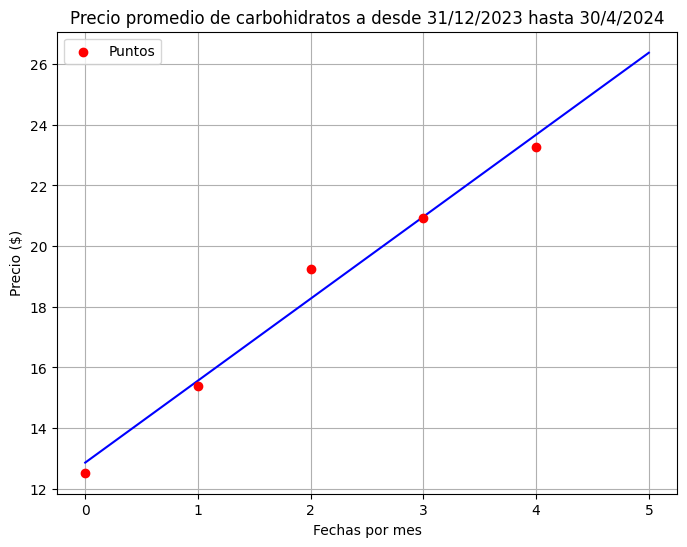

In [71]:
X = np.array([[1,0],[1,1],[1,2],[1,3],[1,4]])
Y = promedioHC_fecha

x = minimosCuadrados(X,Y)

a = x[0]
b = x[1]

# Generar valores de x para la recta
r = np.linspace(0, 5, 100)
y_line = a + b * r

# Definir el conjunto de puntos
points_x = np.array([0, 1, 2, 3, 4])
points_y = np.array(promedioHC_fecha)

# Crear el gráfico
plt.figure(figsize=(8, 6))

# Graficar la recta y = a + bx
plt.plot(r, y_line, color='blue')

# Graficar los puntos
plt.scatter(points_x, points_y, color='red', label='Puntos', zorder=5)

# Añadir etiquetas y título
plt.xlabel('Fechas por mes')
plt.ylabel('Precio ($)')

plt.title('Precio promedio de carbohidratos a desde 31/12/2023 hasta 30/4/2024')
plt.legend()

# Mostrar el gráfico
plt.grid(True)
plt.show()

# Calculamos la recta y graficamos las proteínas

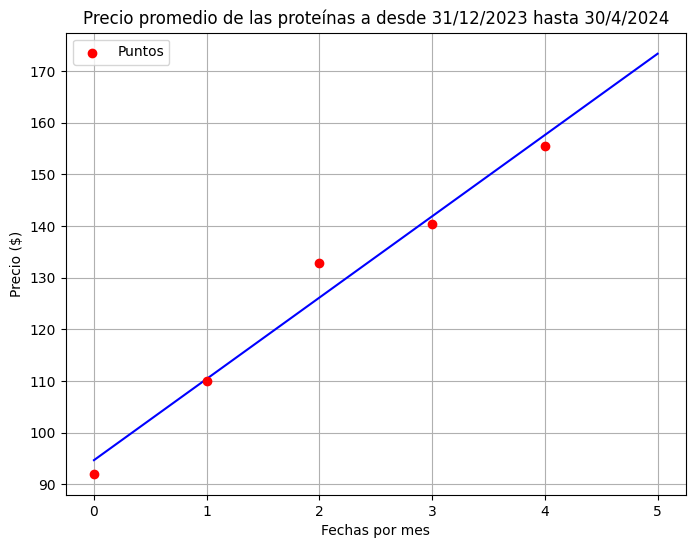

In [72]:
X = np.array([[1,0],[1,1],[1,2],[1,3],[1,4]])
Y = promedioProt_fecha

x = minimosCuadrados(X,Y)

a = x[0]
b = x[1]

# Generar valores de x para la recta
r = np.linspace(0, 5, 100)
y_line = a + b * r

# Definir el conjunto de puntos
points_x = np.array([0, 1, 2, 3, 4])
points_y = np.array(promedioProt_fecha)

# Crear el gráfico
plt.figure(figsize=(8, 6))

# Graficar la recta y = a + bx
plt.plot(r, y_line, color='blue')

# Graficar los puntos
plt.scatter(points_x, points_y, color='red', label='Puntos', zorder=5)

# Añadir etiquetas y título
plt.xlabel('Fechas por mes')
plt.ylabel('Precio ($)')

plt.title('Precio promedio de las proteínas a desde 31/12/2023 hasta 30/4/2024')
plt.legend()

# Mostrar el gráfico
plt.grid(True)
plt.show()

# Calculamos la recta y graficamos las grasas

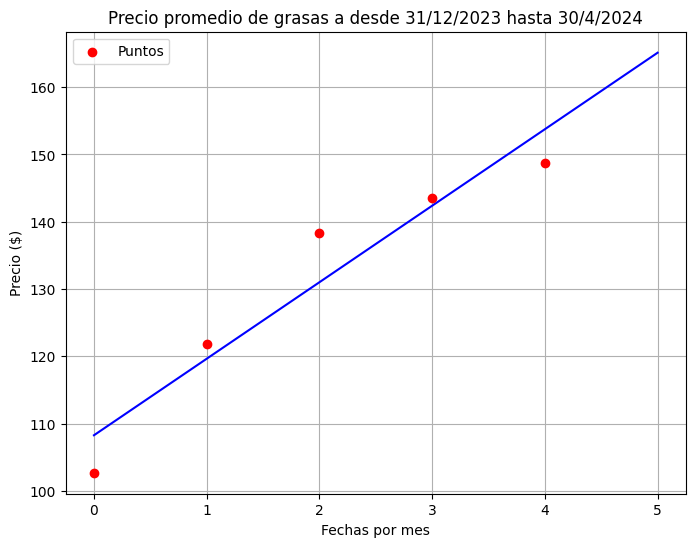

In [73]:
X = np.array([[1,0],[1,1],[1,2],[1,3],[1,4]])
Y = promedioGrasas_fecha

x = minimosCuadrados(X,Y)

a = x[0]
b = x[1]

# Generar valores de x para la recta
r = np.linspace(0, 5, 100)
y_line = a + b * r

# Definir el conjunto de puntos
points_x = np.array([0, 1, 2, 3, 4])
points_y = np.array(promedioGrasas_fecha)

# Crear el gráfico
plt.figure(figsize=(8, 6))

# Graficar la recta y = a + bx
plt.plot(r, y_line, color='blue')

# Graficar los puntos
plt.scatter(points_x, points_y, color='red', label='Puntos', zorder=5)

# Añadir etiquetas y título
plt.xlabel('Fechas por mes')
plt.ylabel('Precio ($)')

plt.title('Precio promedio de grasas a desde 31/12/2023 hasta 30/4/2024')
plt.legend()

# Mostrar el gráfico
plt.grid(True)
plt.show()

# En conjunto, tenemos:

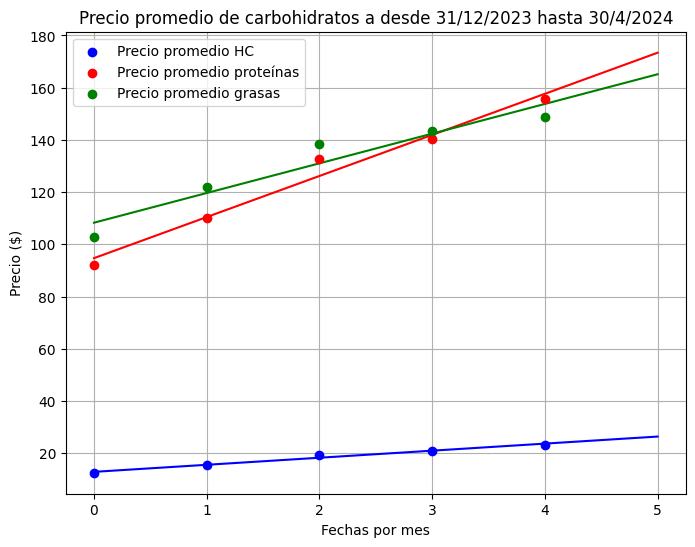

In [74]:
X = np.array([[1,0],[1,1],[1,2],[1,3],[1,4]])
Y = promedioHC_fecha

x = minimosCuadrados(X,Y)

a = x[0]
b = x[1]

# Generar valores de x para la recta
r = np.linspace(0, 5, 100)
y_line = a + b * r

# Definir el conjunto de puntos
points_x = np.array([0, 1, 2, 3, 4])
points_y = np.array(promedioHC_fecha)

# Crear el gráfico
plt.figure(figsize=(8, 6))

# Graficar la recta y = a + bx
plt.plot(r, y_line, color='blue')

# Graficar los puntos
plt.scatter(points_x, points_y, color='blue', label='Precio promedio HC', zorder=5)

Y = promedioProt_fecha

x = minimosCuadrados(X,Y)

a = x[0]
b = x[1]

# Generar valores de x para la recta
r = np.linspace(0, 5, 100)
y_line = a + b * r

# Definir el conjunto de puntos
points_x = np.array([0, 1, 2, 3, 4])
points_y = np.array(promedioProt_fecha)

# Graficar la recta y = a + bx
plt.plot(r, y_line, color='red')

# Graficar los puntos
plt.scatter(points_x, points_y, color='red', label='Precio promedio proteínas', zorder=5)

Y = promedioGrasas_fecha

x = minimosCuadrados(X,Y)

a = x[0]
b = x[1]

# Generar valores de x para la recta
r = np.linspace(0, 5, 100)
y_line = a + b * r

# Definir el conjunto de puntos
points_x = np.array([0, 1, 2, 3, 4])
points_y = np.array(promedioGrasas_fecha)

# Graficar la recta y = a + bx
plt.plot(r, y_line, color='green')

# Graficar los puntos
plt.scatter(points_x, points_y, color='green', label='Precio promedio grasas', zorder=5)



# Añadir etiquetas y título
plt.xlabel('Fechas por mes')
plt.ylabel('Precio ($)')
plt.title('Precio promedio de carbohidratos a desde 31/12/2023 hasta 30/4/2024')
plt.legend()

# Mostrar el gráfico
plt.grid(True)
plt.show()

## Consigna 6 - Comparar el aumento de la carne en comparación con los otros rubros.

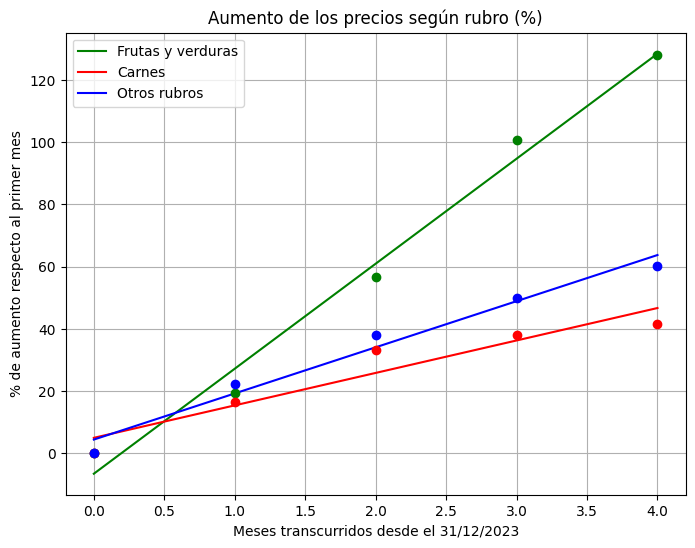

In [75]:
# Modifico la tabla para que me muestre los nutrientes por gramo

cantidades = consumidores_libres[consumidores_libres.columns[1]]
cl = consumidores_libres.copy()
for i in range(cl.shape[0]):
    cl.iloc[i,1:] = cl.iloc[i,1:]/cantidades[i]

# Modifico la tabla para que me muestra el porcentaje de aumento en cada mes según el primer mes

precios = cl[cl.columns[2]]

for i in range(cl.shape[0]):
    for j in range(3,7):
        cl.iloc[i,j] = (cl.iloc[i,j]/precios[i])*100 - 100
    cl.iloc[i,2] = 0

# Reparto el dataframe en rubros y saco un promedio de el aumento de precios según cada mes

frutas_verduras_cl = cl[8:17]
carnes_cl = cl[17:21]
otroRubros_cl = cl[0:8]

frutas_verduras_promedios = []
for i in range(2,7):
    frutas_verduras_promedios.append(frutas_verduras_cl.iloc[:,i].mean())

carnes_promedios = []
for i in range(2,7):
    carnes_promedios.append(carnes_cl.iloc[:,i].mean())

otrosRubros_promedios = []
for i in range(2,7):
    otrosRubros_promedios.append(otroRubros_cl.iloc[:,i].mean())


X = np.array([[1,0],[1,1],[1,2],[1,3],[1,4]])

recta_FV = minimosCuadrados(X,frutas_verduras_promedios)
recta_carnes = minimosCuadrados(X,carnes_promedios)
recta_otrosRubros  = minimosCuadrados(X, otrosRubros_promedios)

a_FV = recta_FV[0]
b_FV = recta_FV[1]

a_Carnes = recta_carnes[0]
b_Carnes = recta_carnes[1]

a_otrosRubros = recta_otrosRubros[0]
b_otrosRubros = recta_otrosRubros[1]

r = np.linspace(0, 4, 100)
y_FV = a_FV + b_FV * r
y_Carnes = a_Carnes + b_Carnes * r
y_otrosRubros = a_otrosRubros + b_otrosRubros * r

# Definir el conjunto de puntos
puntos_x = np.array([0, 1, 2, 3, 4])

plt.figure(figsize=(8, 6))

plt.plot(r, y_FV, color='green', label = "Frutas y verduras")
plt.plot(r, y_Carnes, color='red', label = "Carnes")
plt.plot(r, y_otrosRubros, color='blue', label = "Otros rubros")

# Graficar los puntos
plt.scatter(puntos_x, frutas_verduras_promedios, color='green', zorder=5)
plt.scatter(puntos_x, carnes_promedios, color='red', zorder=5)
plt.scatter(puntos_x, otrosRubros_promedios, color='blue', zorder=5)

plt.xlabel('Meses transcurridos desde el 31/12/2023')
plt.ylabel('% de aumento respecto al primer mes')
plt.title('Aumento de los precios según rubro (%)')
plt.legend()

# Mostrar el gráfico
plt.grid(True)
plt.show()

Se puede apreciar que la carne aumentó en más del 40%, estoy es, sin embargo, menos de lo que aumentan otros rubros, como por ejemplo las frutas y verduras que aumentan más del 120%.
Si quitáramos el 40% del consumo de carne a nuestra dieta (a la canasta básica) esta claramente no cumpliría los márgenes establecidos por la OMS, ya que sabemos que la canasta básica no los cumple.

## Consigna 7 -Proponer dos alimentos de la tabla 3 que lleguen a reemplazar la disminución del 18.5 % de la carne.

In [86]:
# Calculo el déficit de nutrientes al quitar un 18.8% de consumo de carne

carnes = ["Bola de Lomo","pollo","Paleta","Hueso c/carne","Carne picada","Higado","pescado","Asado","Mortadela",
          "Caldo conc.","Paleta cocida"]
tn_carnes = tn[tn["Alimento"].isin(carnes)]
tn_carnes_menos = tn_carnes.copy()
for i in range(tn_carnes.shape[0]):
    for j in range(1,tn_carnes.shape[1]):
        tn_carnes_menos.iloc[i,j] = tn_carnes.iloc[i,j] - (tn_carnes.iloc[i,j]/100)*18.5

tn_deficit = tn_carnes.iloc[:,2:].sum(axis=0) - tn_carnes_menos.iloc[:,2:].sum(axis=0)
tn_deficit

HC (gr)                 0.149850
Proteinas (gr)          7.893950
Grasas (gr)             2.961850
Na (gr)                 0.076884
Ca (gr)                 0.005014
Fe (gr)                 0.000979
Azucares Libres (gr)    0.000000
AGS (gr)                1.811150
AGNI (gr)               2.065155
AG p (gr)               0.399230
Fibra (gr)              0.000000
dtype: float64